In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM, Dense, Dropout
import csv

In [2]:
# Define the folder path where the CSV files are located
folder_path = r'C:\Users\33766\Desktop\mlipproject\data'

# Use the glob module to find all CSV files in the folder
csv_files = glob.glob(f'{folder_path}/*.csv')

# Define the column names that you want to keep
columns_to_keep = ['annee_numero_de_tirage', 'boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'etoile_1', 'etoile_2']

# Initialize an empty DataFrame to hold data from all files
df = pd.DataFrame()

# Iterate over each CSV file
for file in csv_files:
    # Read the CSV file, only keeping specified columns and setting encoding, separator, and index column parameters
    df_temp = pd.read_csv(file, encoding='ISO-8859-1', sep=';', index_col=False, usecols=columns_to_keep)
    # Append the data to the combined DataFrame
    df = pd.concat([df, df_temp], ignore_index=True)

# Sort the combined DataFrame by 'annee_numero_de_tirage' in ascending order
df.sort_values(by='annee_numero_de_tirage', inplace=True)
# Reset the index of the combined DataFrame
df.reset_index(drop=True, inplace=True)


In [3]:
df

,annee_numero_de_tirage,boule_1,boule_2,boule_3,boule_4,boule_5,etoile_1,etoile_2
0,2004001,32,16,29,41,36,9,7
1,2004002,13,50,47,7,39,2,5
2,2004003,37,19,18,14,31,5,4
3,2004004,39,37,4,7,33,5,1
4,2004005,44,47,15,28,24,4,5
...,...,...,...,...,...,...,...,...
1703,20244006,50,27,28,48,44,7,12
1704,20244007,48,23,14,50,39,12,3
1705,20244008,32,19,41,8,42,12,9
1706,20244009,10,27,5,30,19,6,5


In [4]:
# 计算基本统计量
stats = df.describe()
print(stats)

       annee_numero_de_tirage      boule_1      boule_2      boule_3  \
count            1.708000e+03  1708.000000  1708.000000  1708.000000   
mean             6.468151e+06    25.564403    24.980679    25.938525   
std              7.828967e+06    14.417166    14.335759    14.163009   
min              2.004001e+06     1.000000     1.000000     1.000000   
25%              2.011068e+06    13.000000    13.000000    14.000000   
50%              2.015096e+06    26.000000    25.000000    26.000000   
75%              2.019329e+06    38.000000    38.000000    38.000000   
max              2.024401e+07    50.000000    50.000000    50.000000   

           boule_4      boule_5     etoile_1     etoile_2  
count  1708.000000  1708.000000  1708.000000  1708.000000  
mean     25.400468    25.469555     6.075527     5.966628  
std      14.518277    14.390679     3.251538     3.250803  
min       1.000000     1.000000     1.000000     1.000000  
25%      13.000000    13.000000     3.000000     3.

#### 每个球频率

In [5]:
# 分开绘制主球号的频率分布
for i in range(1, 6):  # 对于主球号
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=df[f'boule_{i}'], nbinsx=50, marker_color='blue', name=f'boule_{i}'))
    fig.update_layout(
        title_text=f'Frequency of boule_{i}',
        xaxis_title_text='Number',
        yaxis_title_text='Frequency',
        bargap=0.2,  # 间距
    )
    fig.show()

# 分开绘制星号的频率分布
for i in range(1, 3):  # 对于星号
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=df[f'etoile_{i}'], nbinsx=12, marker_color='red', name=f'etoile_{i}'))
    fig.update_layout(
        title_text=f'Frequency of etoile_{i}',
        xaxis_title_text='Number',
        yaxis_title_text='Frequency',
        bargap=0.2,  # 间距
    )
    fig.show()


#### 啥也不是热力图

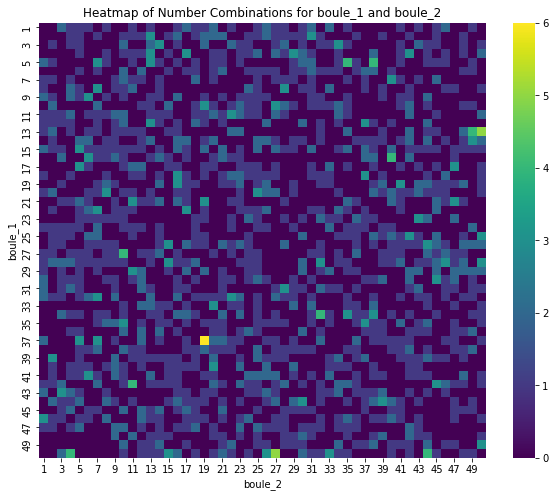

In [6]:
# 创建数字组合的频率矩阵
cross_tab = pd.crosstab(index=df['boule_1'], columns=df['boule_2'])

# 绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, cmap='viridis')
plt.title('Heatmap of Number Combinations for boule_1 and boule_2')
plt.show()


##### 相关性矩阵

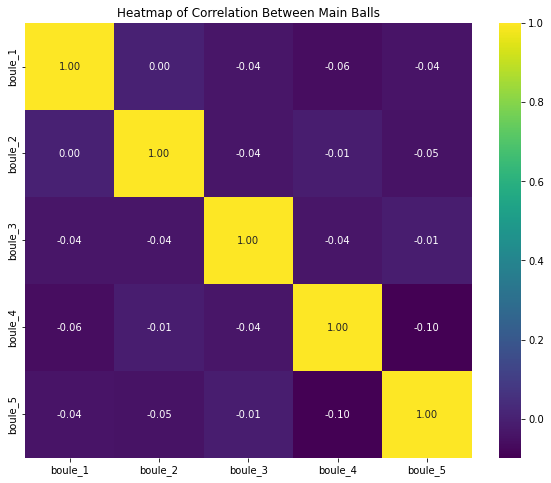

In [7]:
cross_tab = pd.crosstab(index=df['boule_1'], columns=[df['boule_2'], df['boule_3'], df['boule_4'], df['boule_5']])

# 计算五个主球之间的相关性矩阵
corr_matrix = df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']].corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Correlation Between Main Balls')
plt.show()

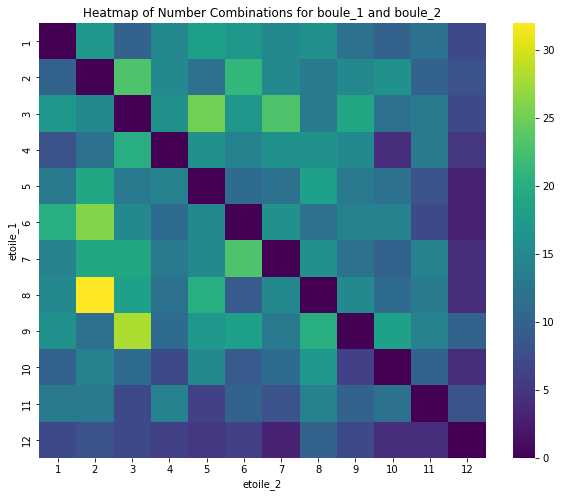

In [8]:
# 创建数字组合的频率矩阵
cross_tab = pd.crosstab(index=df['etoile_1'], columns=df['etoile_2'])

# 绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, cmap='viridis')
plt.title('Heatmap of Number Combinations for boule_1 and boule_2')
plt.show()


#### 绘制每年平均号码的变化趋势

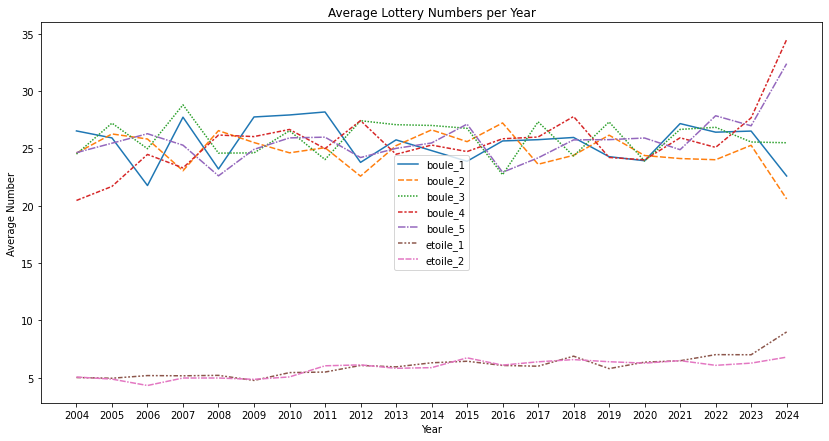

In [9]:
# 假设 'annee_numero_de_tirage' 是年份+编号的格式，先提取年份
df['year'] = df['annee_numero_de_tirage'].apply(lambda x: str(x)[:4])

# 计算每年的平均号码
average_numbers_per_year = df.groupby('year').mean()

# 绘制每年平均号码的变化趋势
plt.figure(figsize=(14, 7))
sns.lineplot(data=average_numbers_per_year[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'etoile_1', 'etoile_2']])
plt.title('Average Lottery Numbers per Year')
plt.ylabel('Average Number')
plt.xlabel('Year')
plt.show()


#### 绘制每年最多出现号码的变化趋势

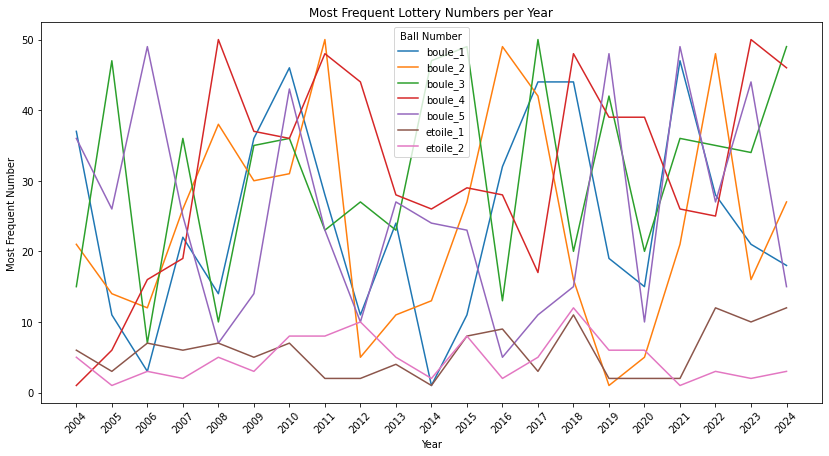

In [10]:
# 初始化存储每年最多出现号码的 DataFrame
most_frequent_numbers_per_year = pd.DataFrame()

# 对每个球号进行操作
for ball in ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'etoile_1', 'etoile_2']:
    # 初始化一个列表来存储每年最频繁的数字
    most_frequent_numbers = []
    
    # 对每个年份进行操作
    for year in df['year'].unique():
        # 筛选当前年份的数据
        year_df = df[df['year'] == year]
        
        # 计算当前年份当前球号的数字频率，并找到频率最高的数字
        most_frequent_number = year_df[ball].value_counts().idxmax()
        
        # 将最频繁的数字添加到列表中
        most_frequent_numbers.append(most_frequent_number)
    
    # 将每年最频繁的数字加入到 DataFrame 中
    most_frequent_numbers_per_year[ball] = most_frequent_numbers

# 设置年份为索引
most_frequent_numbers_per_year.index = df['year'].unique()

# 绘制每年最频繁出现的数字的变化趋势
plt.figure(figsize=(14, 7))
for ball in most_frequent_numbers_per_year.columns:
    sns.lineplot(data=most_frequent_numbers_per_year[ball], label=ball)
plt.title('Most Frequent Lottery Numbers per Year')
plt.ylabel('Most Frequent Number')
plt.xlabel('Year')
plt.legend(title='Ball Number')
plt.xticks(rotation=45)  # 旋转 x 轴标签以便更好地显示
plt.show()


#### 检测异常值

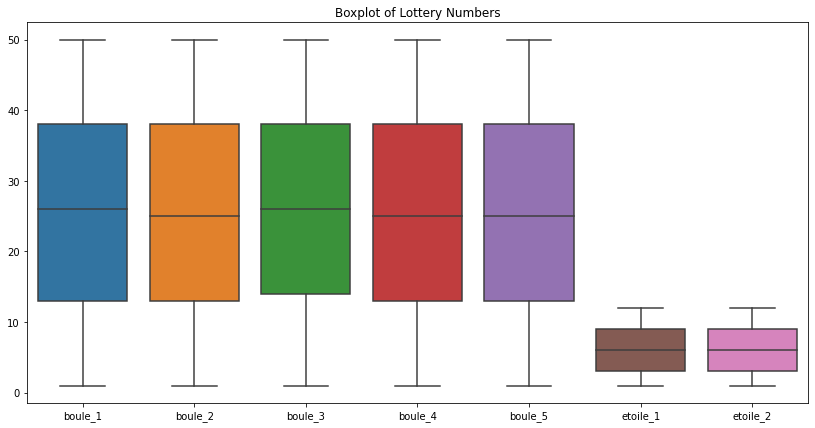

In [11]:
# 使用箱线图来检测每个数字的潜在异常值
plt.figure(figsize=(14, 7))
sns.boxplot(data=df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'etoile_1', 'etoile_2']])
plt.title('Boxplot of Lottery Numbers')
plt.show()


#### 预测模型

In [12]:
df = df.drop(['annee_numero_de_tirage','year'], axis=1)
df.head()

,boule_1,boule_2,boule_3,boule_4,boule_5,etoile_1,etoile_2
0,32,16,29,41,36,9,7
1,13,50,47,7,39,2,5
2,37,19,18,14,31,5,4
3,39,37,4,7,33,5,1
4,44,47,15,28,24,4,5


In [13]:
scaler = StandardScaler().fit(df.values)
transformed_dataset = scaler.transform(df.values)
transformed_df = pd.DataFrame(data=transformed_dataset, index=df.index)
transformed_df.head()

,0,1,2,3,4,5,6
0,0.446515,-0.626636,0.216223,1.074790,0.731969,0.899676,0.317975
1,-0.871744,1.745750,1.487512,-1.267771,0.940498,-1.253782,-0.297438
2,0.793425,-0.417308,-0.560675,-0.785479,0.384420,-0.330872,-0.605144
3,0.932190,0.838661,-1.549455,-1.267771,0.523440,-0.330872,-1.528263
4,1.279100,1.536422,-0.772557,0.179105,-0.102148,-0.638509,-0.297438


In [14]:
number_of_rows= df.values.shape[0] #all our games
window_length = 5 #amount of past games we need to take in consideration for prediction
number_of_features = df.values.shape[1] #balls count

In [15]:
train = np.empty([number_of_rows-window_length, window_length, number_of_features], dtype=float)
label = np.empty([number_of_rows-window_length, number_of_features], dtype=float)

for i in range(0, number_of_rows-window_length):
    train[i]=transformed_df.iloc[i:i+window_length, 0: number_of_features]
    label[i]=transformed_df.iloc[i+window_length: i+window_length+1, 0: number_of_features]

In [16]:
train.shape

(1703, 5, 7)

In [17]:
label.shape

(1703, 7)

In [18]:
train[0]

array([[ 0.44651509, -0.62663647,  0.21622326,  1.0747901 ,  0.73196888,
         0.89967563,  0.31797529],
       [-0.87174434,  1.74574982,  1.48751183, -1.26777148,  0.94049822,
        -1.2537822 , -0.29743751],
       [ 0.79342546, -0.41730827, -0.56067531, -0.78547939,  0.38442   ,
        -0.3308717 , -0.60514391],
       [ 0.93218961,  0.83866094, -1.5494553 , -1.26777148,  0.52343955,
        -0.3308717 , -1.5282631 ],
       [ 1.27909998,  1.53642161, -0.77255674,  0.17910479, -0.10214844,
        -0.63850853, -0.29743751]])

In [19]:
train[1]

array([[-0.87174434,  1.74574982,  1.48751183, -1.26777148,  0.94049822,
        -1.2537822 , -0.29743751],
       [ 0.79342546, -0.41730827, -0.56067531, -0.78547939,  0.38442   ,
        -0.3308717 , -0.60514391],
       [ 0.93218961,  0.83866094, -1.5494553 , -1.26777148,  0.52343955,
        -0.3308717 , -1.5282631 ],
       [ 1.27909998,  1.53642161, -0.77255674,  0.17910479, -0.10214844,
        -0.63850853, -0.29743751],
       [ 1.14033583,  1.39686948,  0.49873183,  0.79919462,  0.73196888,
         0.89967563, -0.60514391]])

In [20]:
label[0]

array([ 1.14033583,  1.39686948,  0.49873183,  0.79919462,  0.73196888,
        0.89967563, -0.60514391])

In [21]:
label[1]

array([-0.17792359,  1.25731734, -1.62008245, -1.47446809, -1.07528532,
       -1.2537822 , -0.60514391])

In [22]:
batch_size = 25 
if os.path.exists('/Users/dantashashou/Downloads/euromillions/euromillions.h5'):
    model = load_model('/Users/dantashashou/Downloads/euromillions/euromillions.h5')
else:
    model = Sequential()
    model.add(LSTM(32,      
               input_shape=(window_length, number_of_features),
               return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32,           
               return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(number_of_features))
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(train, label, batch_size=64, epochs=100)
    # model.save('input/'+filename+'.h5')

Epoch 1/100
27/27 [==============================] - 2s 4ms/step - loss: 1.0025
Epoch 2/100
27/27 [==============================] - 0s 5ms/step - loss: 0.9989
Epoch 3/100
27/27 [==============================] - 0s 4ms/step - loss: 0.9988
Epoch 4/100
27/27 [==============================] - 0s 4ms/step - loss: 0.9966
Epoch 5/100
27/27 [==============================] - 0s 4ms/step - loss: 0.9953
Epoch 6/100
27/27 [==============================] - 0s 4ms/step - loss: 0.9954
Epoch 7/100
27/27 [==============================] - 0s 4ms/step - loss: 0.9946
Epoch 8/100
27/27 [==============================] - 0s 5ms/step - loss: 0.9937
Epoch 9/100
27/27 [==============================] - 0s 4ms/step - loss: 0.9921
Epoch 10/100
27/27 [==============================] - 0s 4ms/step - loss: 0.9927
Epoch 11/100
27/27 [==============================] - 0s 4ms/step - loss: 0.9914
Epoch 12/100
27/27 [==============================] - 0s 4ms/step - loss: 0.9903
Epoch 13/100
27/27 [=================

In [23]:
to_predict=df.iloc[-5:]
scaled_to_predict = scaler.transform(to_predict)

c:\Users\33766\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



In [24]:
scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))
data = scaler.inverse_transform(scaled_predicted_output_1).astype(int)
predict = pd.DataFrame(data, columns=['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'etoile_1', 'etoile_2'])
# df.to_csv(''+filename+'.csv', index=False)  
predict

,boule_1,boule_2,boule_3,boule_4,boule_5,etoile_1,etoile_2
0,21,22,26,28,20,6,7
